The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
depthImage shape: (200, 200)
pixel_output_array size: 200x200
200


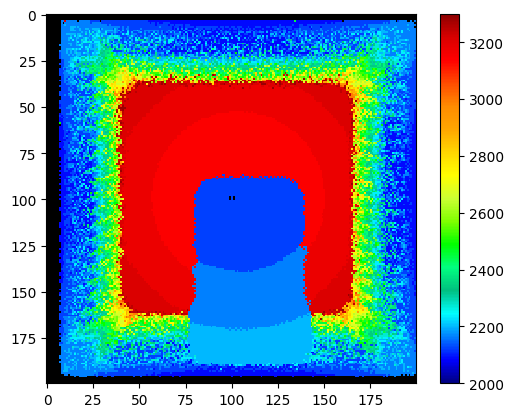

In [ ]:
%load_ext autoreload
%autoreload 2
from pythonLib.pixelationLib import*
from pythonLib.formImageLib import*
# input_file_path = "../singleTest/single_rawData.h5"
input_file_path = "../positive/rawData/positive_rawData_520.h5"
input_fov, input_height, input_width = read_file_parameter(input_file_path) 

image_width = 200
image_height = 200
fov = 35
# Initialize detector
mydetector = detector(0.01, fov, image_width, image_height)

# Read and process photons
photons, failed_lines = read_raw_data(input_file_path)

print(len(photons))
for photon in photons:
    mydetector.photon_to_dector(photon)
pixels,image_width,image_height = mydetector.output_to_array()

range_min = 2000
range_max = 3300
input_bin_number = 36
myRange = [range_min,range_max]
image, illegal_photon, stamped_histogram, stamped_collosioin = form_histogram_image(pixels, image_height,image_width,bin_number=input_bin_number,range_distance=myRange)
display_image(image,None,distance_range=myRange)